In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
CACHE_DIR = f"/scratch/{os.getenv('USER')}/huggingface_cache"

# Collect LM hidden states

In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

torch.random.manual_seed(0)

model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct", 
    device_map="cuda", 
    torch_dtype="auto", 
    trust_remote_code=True, 
    cache_dir=CACHE_DIR
)
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct", cache_dir=CACHE_DIR)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
model

Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3Attention(
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear(in_features=3072, out_features=9216, bias=False)
          (rotary_emb): Phi3RotaryEmbedding()
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLU()
        )
        (input_layernorm): Phi3RMSNorm()
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
        (post_attention_layernorm): Phi3RMSNorm()
      )
    )
    (norm): Phi3RMSNorm()
  )
  (lm_head): Linear(in_features=3072, out_features=3206

In [47]:
from transformers.pipelines.text_generation import TextGenerationPipeline, ReturnType
import numpy as np

class CustomPipeline(TextGenerationPipeline):
    
    def _forward(self, model_inputs, **generate_kwargs):
        input_ids = model_inputs["input_ids"]
        attention_mask = model_inputs.get("attention_mask", None)
        # Allow empty prompts
        if input_ids.shape[1] == 0:
            input_ids = None
            attention_mask = None
            in_b = 1
        else:
            in_b = input_ids.shape[0]
        prompt_text = model_inputs.pop("prompt_text")

        # If there is a prefix, we may need to adjust the generation length. Do so without permanently modifying
        # generate_kwargs, as some of the parameterization may come from the initialization of the pipeline.
        prefix_length = generate_kwargs.pop("prefix_length", 0)
        if prefix_length > 0:
            has_max_new_tokens = "max_new_tokens" in generate_kwargs or (
                "generation_config" in generate_kwargs
                and generate_kwargs["generation_config"].max_new_tokens is not None
            )
            if not has_max_new_tokens:
                generate_kwargs["max_length"] = generate_kwargs.get("max_length") or self.model.config.max_length
                generate_kwargs["max_length"] += prefix_length
            has_min_new_tokens = "min_new_tokens" in generate_kwargs or (
                "generation_config" in generate_kwargs
                and generate_kwargs["generation_config"].min_new_tokens is not None
            )
            if not has_min_new_tokens and "min_length" in generate_kwargs:
                generate_kwargs["min_length"] += prefix_length

        # BS x SL
        outputs = self.model.generate(input_ids=input_ids, attention_mask=attention_mask, return_dict_in_generate=True, **generate_kwargs)

        n_layers = len(outputs.hidden_states[0][1:])
        n_tokens = len(outputs.hidden_states[0][0][0, :, 0])
        data = np.full((n_tokens, n_layers), None, dtype=object)         

        for i, layer_hidden_state in enumerate(outputs.hidden_states[0]):
            if i == 0:  # skip the embedding layer
                continue
            for j in range(n_tokens):
                data[j, i-1] = layer_hidden_state[0, j, :].to(torch.float16).detach().cpu().numpy()

        generated_sequence = outputs.sequences
        
        out_b = generated_sequence.shape[0]
        if self.framework == "pt":
            generated_sequence = generated_sequence.reshape(in_b, out_b // in_b, *generated_sequence.shape[1:])
        elif self.framework == "tf":
            generated_sequence = tf.reshape(generated_sequence, (in_b, out_b // in_b, *generated_sequence.shape[1:]))
        return {"generated_sequence": generated_sequence, "input_ids": input_ids, "prompt_text": prompt_text, "hidden_states": data}

    def postprocess(self, model_outputs, return_type=ReturnType.FULL_TEXT, clean_up_tokenization_spaces=True):
        
        # compute the raw decoded tokens in string format
        generated_sequence = model_outputs['generated_sequence'][0,0,:]
        tokens = [tokenizer.decode([token_id], skip_special_tokens=False, clean_up_tokenization_spaces=False) for token_id in generated_sequence]

        result = super().postprocess(model_outputs, return_type, clean_up_tokenization_spaces)
        result.append({"tokens": tokens})
        result.append({"hidden_states": model_outputs["hidden_states"]})
        return result

In [48]:
import pandas as pd
 
messages = "The Space Needle is located in downtown"
messages = "The University of Virginia is located in the city of"
max_new_tokens = 1

pipe = CustomPipeline(
    model=model,
    tokenizer=tokenizer
)

generation_args = {
    "max_new_tokens": max_new_tokens,
    "return_full_text": False,
    "temperature": 0.0,
    "output_hidden_states": True,
}

output = pipe(messages, **generation_args)

tokenized_input = output[1]['tokens'][:-max_new_tokens]
generated_text = output[0]['generated_text']
tokenized_output = output[1]['tokens']
hidden_states = output[2]["hidden_states"]

print("Tokenized Input: ", tokenized_input)
print("Tokenized Output: ", tokenized_output)

# visualize the hidden states. This data will be used for the Bayesian Network
df = pd.DataFrame(hidden_states)
df.columns = ['layer {}'.format(i+1) for i in range(df.shape[1])]
df.index = [tokenized_input]
df

Tokenized Input:  ['The', 'University', 'of', 'Virginia', 'is', 'located', 'in', 'the', 'city', 'of']
Tokenized Output:  ['The', 'University', 'of', 'Virginia', 'is', 'located', 'in', 'the', 'city', 'of', 'Char']


/home/jqm9ba/.conda/envs/nlp/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


,layer 1,layer 2,layer 3,layer 4,layer 5,layer 6,layer 7,layer 8,layer 9,layer 10,...,layer 23,layer 24,layer 25,layer 26,layer 27,layer 28,layer 29,layer 30,layer 31,layer 32
The,"[0.02136, 0.03955, -0.006287, -0.1289, 0.02893...","[0.06055, -0.003418, 0.02124, -0.1816, 0.05225...","[0.0327, -0.1953, -0.03125, -0.3633, -0.1504, ...","[0.04907, -0.1768, -0.031, -0.3281, -0.2695, -...","[0.801, -0.3047, -0.05664, 0.1543, -1.055, 0.3...","[0.8555, -0.2598, -0.03467, 0.1758, -1.047, 0....","[0.824, -0.379, -0.0752, 0.3672, -0.8438, 0.61...","[1.406, -0.707, -0.03027, 0.2432, -1.484, 0.12...","[1.4375, -0.7656, 0.0249, 0.249, -1.4375, 0.15...","[1.469, -0.6094, 0.0679, 0.2695, -1.414, 0.174...",...,"[1.008, -1.828, 0.9062, 0.04053, -1.75, 1.125,...","[1.047, -2.078, 1.1875, 0.1357, -1.5625, 1.055...","[1.141, -2.14, 1.32, 0.3809, -1.586, 1.016, 0....","[1.3125, -2.344, 1.625, 0.5664, -1.422, 0.953,...","[1.18, -2.312, 1.844, 0.582, -1.1875, 0.957, 0...","[0.9453, -2.172, 1.602, 0.1797, -1.219, 0.664,...","[1.445, -2.516, 2.5, 0.2832, -1.633, 0.3867, 0...","[1.016, -0.75, 0.711, -1.094, 0.2422, 0.1309, ...","[1.32, -0.879, 1.953, -0.711, -0.7734, 0.1289,...","[-0.3477, 0.3184, -0.1426, -0.0996, 0.3828, -0..."
University,"[-0.02417, -0.006836, -0.01794, 0.08594, 0.038...","[0.012695, -0.0349, -0.0547, 0.1406, 0.1768, -...","[0.04834, 0.09766, 0.01196, 0.2344, 0.1963, -0...","[0.1484, 0.1553, 0.04785, 0.3828, 0.3516, -0.1...","[0.1836, 0.371, 0.01648, 0.3828, 0.25, -0.1631...","[0.2295, 0.377, -0.007324, 0.4492, 0.1797, -0....","[0.336, 0.457, -0.0381, 0.1562, 0.09375, 0.041...","[0.4395, 0.457, -0.04248, 0.21, -0.1523, -0.05...","[0.4492, 0.5625, -0.0713, 0.05273, -0.1875, 0....","[0.1582, 0.7812, -0.04395, 0.1709, -0.012695, ...",...,"[1.102, 3.25, -4.156, 1.242, -0.617, -0.2207, ...","[0.926, 3.453, -5.156, 2.75, 0.2852, -0.3281, ...","[1.016, 3.812, -5.594, 2.719, -0.498, 0.7188, ...","[1.078, 2.672, -7.22, 4.22, -0.547, 1.023, 0.0...","[1.57, 3.094, -7.562, 4.875, -0.02734, 0.1953,...","[-0.0625, 3.312, -8.56, 6.688, -0.4805, 1.266,...","[-0.3066, 1.078, -7.03, 7.094, -0.1895, 0.2578...","[-0.5195, 2.062, -5.78, 7.406, -1.086, 1.078, ...","[-1.055, 2.938, -5.97, 7.875, 0.5703, 2.672, -...","[-0.5195, 0.832, -1.094, 2.375, 0.4434, 0.715,..."
of,"[-0.03857, 0.0415, 0.04834, -0.01477, -0.00015...","[-0.0664, 0.0698, 0.04932, -0.02173, 0.03516, ...","[0.06128, -0.02832, -0.1138, -0.02893, 0.01147...","[0.06055, 0.0376, -0.582, -0.3125, 0.06226, -0...","[0.09766, 0.2207, -0.6055, -0.4883, 0.08203, -...","[0.0952, 0.5312, -0.6406, -0.789, 0.01343, 0.1...","[0.455, 0.6953, -0.996, -0.824, -0.1846, 0.034...","[0.3145, 0.9297, -1.203, -0.66, -0.1465, 0.089...","[0.3633, 1.328, -1.0, -0.625, -0.2461, 0.3457,...","[0.3867, 1.5625, -1.281, -0.4766, -0.1533, 0.2...",...,"[-1.336, 2.969, -3.14, 1.078, 0.2344, -1.148, ...","[-0.9297, 3.562, -3.875, 1.055, 0.04102, -1.12...","[-0.8203, 4.344, -4.625, 1.547, 0.3633, -1.141...","[0.1797, 4.938, -4.78, 1.43, 0.0371, -1.109, 0...","[0.295, 5.188, -5.125, 2.312, -0.535, -2.234, ...","[-0.1875, 3.719, -5.47, 2.062, -1.148, -2.36, ...","[1.3125, 3.625, -5.25, 3.266, 0.3672, -4.188, ...","[1.508, 4.688, -4.03, 5.188, -0.1758, -2.766, ...","[0.7617, 4.688, -1.719, 4.72, -0.463, -1.945, ...","[-0.4727, 0.9688, -0.3203, 0.9688, 0.59, -0.10..."
Virginia,"[-0.0703, 0.04712, -0.02466, 0.10986, 0.0884, ...","[-0.007812, 0.052, -0.013306, 0.1221, 0.06885,...","[-0.00482, 0.00598, -0.103, 0.1953, 0.04736, -...","[0.05176, -0.1406, -0.04395, 0.2217, -0.0762, ...","[-0.01953, -0.0879, -0.2012, 0.08887, -0.08496...","[0.3086, 0.2197, 0.0, 0.062, -0.336, 0.455, -0...","[0.824, 0.3242, 0.07715, 0.1914, -0.04297, 0.4...","[0.676, 0.4844, -0.1177, 0.375, -0.1445, 0.515...","[0.6406, 0.6094, -0.254, 0.4043, 0.04736, 0.38...","[0.832, 1.047, -0.91, 0.4766, -0.02075, 0.5117...",...,"[0.664, 2.875, -2.5, -2.438, 1.672, -0.2227, -...","[2.344, 2.188, -1.867, -1.1875, 2.125, -0.2383...","[1.703, 1.547, -2.812, -1.156, 1.812

In [49]:
import matplotlib.pyplot as plt

fig_width = 90  
fig_height = 3

# Create a single figure and set the size
fig, axes = plt.subplots(nrows=len(hidden_states), ncols=len(hidden_states[0]), figsize=(fig_width, fig_height*len(hidden_states)))

# Iterate through each row of hidden_states
for i, (row_data, ylabel) in enumerate(zip(hidden_states, tokenized_input)):
    # Set y-label for the entire row
    axes[i, 0].set_ylabel(ylabel, color="red", fontsize=50)

    # Iterate through each entry in the row
    for j, entry in enumerate(row_data):
        # Plot scatter plot in the corresponding subplot
        axes[i, j].scatter(range(len(entry)), entry, alpha=0.6)
        if i == 0:
            axes[i, j].set_title(f"Layer {j+1}")


# Save the figure
plt.savefig("scatter_plots.png")

# Show the plot
plt.show()

### Parameter Estimation using Bayesian Network

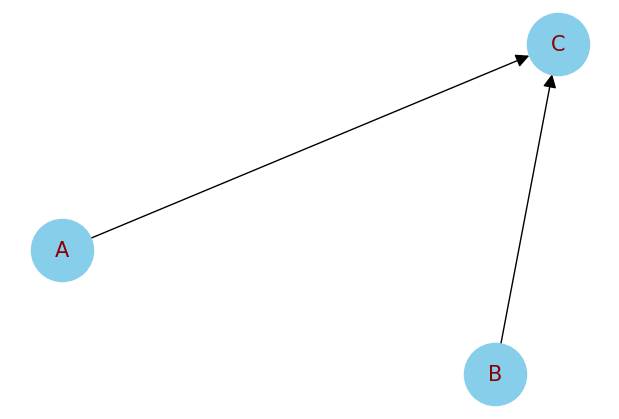

In [ ]:
import pandas as pd
import numpy as np
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
import networkx as nx
import matplotlib.pyplot as plt



# define BN
network = [('A', 'C'), ('B', 'C')]
model = BayesianNetwork(network)
G = nx.DiGraph(network)

plt.figure(figsize=(6, 4))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=2000, font_size=15, font_color='darkred', arrowstyle='-|>', arrowsize=20)
plt.show()

In [24]:
# Data for parameter estimation
data = pd.DataFrame(data={'A': [0, 0, 1], 'B': [0, 1, 0], 'C': [1, 1, 0]})
data

,A,B,C
0,0,0,1
1,0,1,1
2,1,0,0


##### MLE

In [25]:
estimator = MaximumLikelihoodEstimator(model, data)
cpd_A = estimator.estimate_cpd('A')
print(cpd_A)
cpd_C = estimator.estimate_cpd('C')
print(cpd_C)

+------+----------+
| A(0) | 0.666667 |
+------+----------+
| A(1) | 0.333333 |
+------+----------+
+------+------+------+------+------+
| A    | A(0) | A(0) | A(1) | A(1) |
+------+------+------+------+------+
| B    | B(0) | B(1) | B(0) | B(1) |
+------+------+------+------+------+
| C(0) | 0.0  | 0.0  | 1.0  | 0.5  |
+------+------+------+------+------+
| C(1) | 1.0  | 1.0  | 0.0  | 0.5  |
+------+------+------+------+------+


##### Bayesian Estimator

In [10]:
estimator = BayesianEstimator(model, data)
cpd_C = estimator.estimate_cpd('C', prior_type="dirichlet",
                               pseudo_counts=[[1, 1, 1, 1],
                                              [2, 2, 2, 2]])
print(cpd_C)

+------+------+------+------+--------------------+
| A    | A(0) | A(0) | A(1) | A(1)               |
+------+------+------+------+--------------------+
| B    | B(0) | B(1) | B(0) | B(1)               |
+------+------+------+------+--------------------+
| C(0) | 0.25 | 0.25 | 0.5  | 0.3333333333333333 |
+------+------+------+------+--------------------+
| C(1) | 0.75 | 0.75 | 0.5  | 0.6666666666666666 |
+------+------+------+------+--------------------+
